<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Импорт-библиотек" data-toc-modified-id="Импорт-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Импорт библиотек</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Общий-анализ-данных" data-toc-modified-id="Общий-анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Общий анализ данных</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Подборка-лучшей-модели" data-toc-modified-id="Подборка-лучшей-модели-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подборка лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта** - построить модель предсказания количества заказов такси на следующий час.


**Задачи:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы (значение метрики *RMSE* на тестовой выборке должно быть не больше 48).



Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорт библиотек

In [1]:
pip install optuna

In [2]:
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
import optuna

from sklearn.dummy import DummyRegressor

warnings.simplefilter(action='ignore', category=FutureWarning)

### Загрузка данных

In [3]:
server_path = '/datasets/'
local_path = ''
df = 'taxi.csv'

try:
    df = pd.read_csv(server_path + df, index_col=[0], parse_dates=[0])  
except: 
    df = pd.read_csv(local_path + df, index_col=[0], parse_dates=[0])  
  

### Общий анализ данных

Проверим индекс на монотонность.

In [4]:
df.index.is_monotonic

True

Просмотрим последние 5 строк таблицы.

In [5]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проведем ресемплирование.

In [7]:
df = df.resample('1H').sum()

Выполним проверку пропусков и дубликатов.

In [8]:
print('Всего NaN:',df.isnull().sum())

Всего NaN: num_orders    0
dtype: int64


In [9]:
print('Кол-во дубликатов',df.duplicated().sum())

Кол-во дубликатов 4165


Построим график рассеяния для почасовых данных.

In [10]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


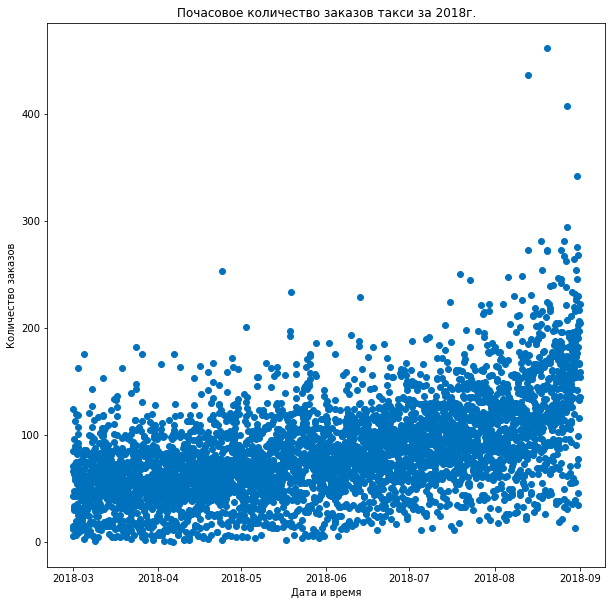

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.scatter(df.index.values,
           df['num_orders'],
           color='#0072BD')

ax.set(xlabel="Дата и время",
       ylabel="Количество заказов",
       title="Почасовое количество заказов такси за 2018г.")

plt.show()

**Вывод:**

- Таблица содержит данные о количестве заказов с марта по сентябрь 2018 года на каждый час.
- В данных нет пропущенных (NaN) значений.
- В данных есть 4165 дубликатов, однако эти дубликаты могут являться следствием большого количества заказов такси примерно в одно время.
- График рассеяния показал что вне зависимости от времени большинство заказов приходится на промежуток от 0 до 100 заказов, однако ближе к сентябрю 2018 минимальное кол-во заказов увеличилось, а также видны выбросы в данных.

## Анализ

Разделим данные на трендовую, сезонную и шумовую состовляющие и построим соответствующие графики.

In [12]:
decomposed = seasonal_decompose(df)

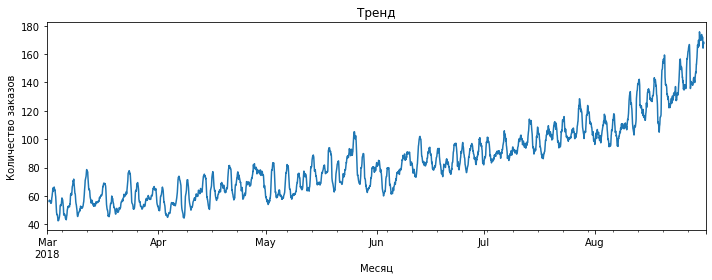

In [13]:
ax = decomposed.trend.plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Тренд')
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество заказов")
plt.tight_layout()

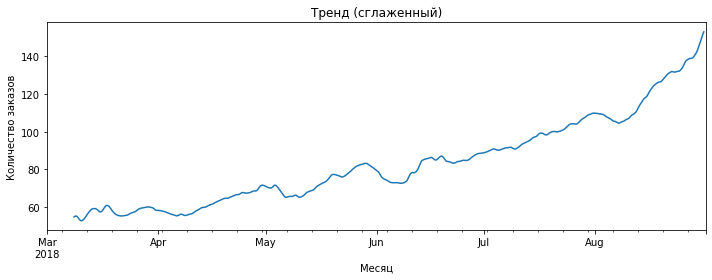

In [14]:
ax = decomposed.trend.rolling(24*7).mean().plot(ax=plt.gca(),figsize=(10, 4)) 
plt.title('Тренд (сглаженный)')
ax.set_xlabel("Месяц")
ax.set_ylabel("Количество заказов")
plt.tight_layout()

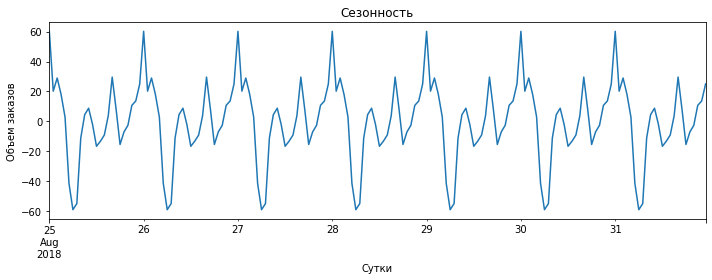

In [15]:
ax = decomposed.seasonal.tail(24*7).plot(ax=plt.gca(),figsize=(10, 4))
plt.title('Сезонность')
ax.set_xlabel("Сутки")
ax.set_ylabel("Объем заказов")
plt.tight_layout()

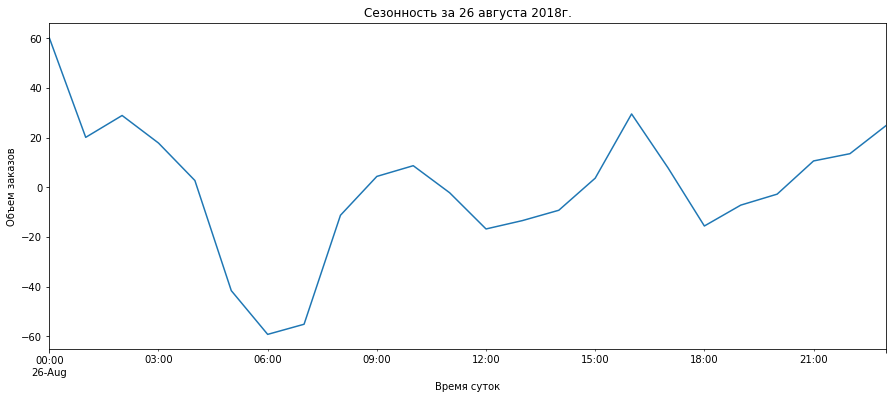

In [16]:
ax = decomposed.seasonal['2018-08-26'].plot(figsize=(15, 6))
ax.set_xlabel("Время суток")
ax.set_ylabel("Объем заказов")
plt.title('Сезонность за 26 августа 2018г.');

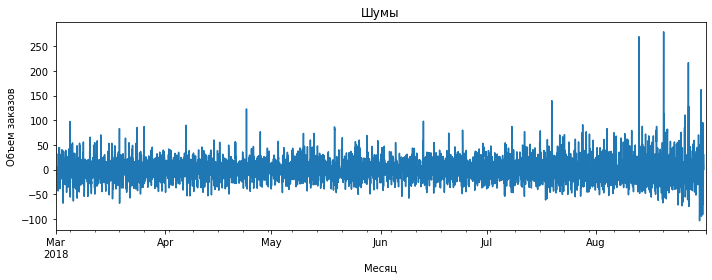

In [17]:
ax = decomposed.resid.plot(ax=plt.gca(),figsize=(10, 4))
ax.set_xlabel("Месяц")
ax.set_ylabel("Объем заказов")
plt.title('Шумы')
plt.tight_layout()

Выводы:

- Наблюдается тренд равномерного роста заказов с периодическими небольшими падениями
- Присутствует сезонность по дням - спад ночью, рост с утра и днем, пик к полуночи. Вероятнее всего обусловлена расписанием рейсов.

Временной ряд в таком виде не является стационарным, так как подвержен тренду, который меняется во времени. Это можно подтвердить критерием Дики-Фуллера.

Нулевая гипотеза гласит: "Временной ряд является нестацинарным". Альтернативная: "Временной ряд стационарен"

In [18]:
p_value = adfuller(df['num_orders'])[1]
print('P =', p_value)
if p_value < 0.05:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

P = 0.02894005140261361
Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера


При явном наличии тренда и сезонности, критерий Дики-Фуллера не значим.

In [ ]:
p_value = adfuller(df['num_orders'])[1]
print('P =', p_value)
if p_value < 0.01:
    print('Нулевая гипотеза отвергается. Ряд стационарен по критерию Дики-Фуллера')
else:
    print('Нулевая гипотеза не отвергается. Ряд нестационарен по критерию Дики-Фуллера')

## Обучение

### Создание признаков

Создание признаков для одношагового прогноза с горизонтом в один час:

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    data = data.copy()
   
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
data = make_features(df,24,24)

Разбиение на обучающую, валидационную и тестовую выборки:

In [21]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [22]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Подборка лучшей модели

In [23]:
%%time
lr = LinearRegression()
lr.fit(features_train, target_train) 
predicted_valid = lr.predict(features_valid) 

print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE валидационной выборки  34.3254397865672
Wall time: 16 ms


In [24]:
%%time
rm = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42) 
rm.fit(features_train, target_train) 
predicted_valid = rm.predict(features_valid) 

print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE валидационной выборки  35.231003959944076
Wall time: 2.08 s


In [25]:
%%time
cb = CatBoostRegressor(n_estimators=200,
                       loss_function='RMSE',
                       learning_rate=0.4,
                       depth=3, 
                       task_type='CPU',
                       random_state=42, 
                       verbose=False)
cb.fit(features_train, target_train)
predicted_valid = cb.predict(features_valid) 


print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE валидационной выборки  32.75143962242094
Wall time: 467 ms


In [26]:
%%time
lgb = LGBMRegressor(n_estimators=200, 
                          learning_rate=0.1, 
                          num_leaves=10, 
                          max_depth=20, 
                          random_state=42) 
lgb.fit(features_train, target_train) 
predicted_valid = lgb.predict(features_valid) 

print("RMSE валидационной выборки ", mean_squared_error(target_valid, predicted_valid) ** 0.5)

RMSE валидационной выборки  31.563561412921
Wall time: 104 ms


catboost и lgbm справляются лучше, попробуем улучшить качество, подобрав параметры.

In [27]:
def objective(trial):

    param = {     
        'depth' : trial.suggest_int("depth", 3, 10),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True)
        
    }

    model = CatBoostRegressor(loss_function='RMSE', task_type='CPU', random_state = 42,verbose=False,  **param)
    model.fit(features_train, target_train)
    preds = model.predict(features_valid)

    RMSE = mean_squared_error(target_valid, preds,squared=False)
    

    return RMSE

In [28]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2023-10-01 08:56:35,760] A new study created in memory with name: no-name-8fc0896d-f634-4871-ae4c-82dded8a5d62
[I 2023-10-01 08:56:42,233] Trial 0 finished with value: 31.30746543060039 and parameters: {'depth': 8, 'n_estimators': 560, 'learning_rate': 0.17450563240817124}. Best is trial 0 with value: 31.30746543060039.
[I 2023-10-01 08:57:08,342] Trial 1 finished with value: 31.210643212377455 and parameters: {'depth': 9, 'n_estimators': 1218, 'learning_rate': 0.010024991066817016}. Best is trial 1 with value: 31.210643212377455.
[I 2023-10-01 08:57:08,662] Trial 2 finished with value: 30.8968053793142 and parameters: {'depth': 5, 'n_estimators': 103, 'learning_rate': 0.16015852567333042}. Best is trial 2 with value: 30.8968053793142.
[I 2023-10-01 08:57:11,258] Trial 3 finished with value: 31.12578546280059 and parameters: {'depth': 3, 'n_estimators': 1912, 'learning_rate': 0.015910018642107646}. Best is trial 2 with value: 30.8968053793142.
[I 2023-10-01 08:57:16,148] Trial 4 fin

Wall time: 16min 8s


In [29]:
cat_param = study.best_params

In [30]:
print("RMSE валидационной выборки: ", study.best_value)

RMSE валидационной выборки:  29.799857745928836


In [31]:
def objective_lgbm(trial):

    param = {     
        'max_depth' : trial.suggest_int("max_depth", 3, 20),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 4000, log=True),
        'learning_rate' : trial.suggest_float('learning_rate', 0.01, 0.4, log=True),
        'num_leaves' : trial.suggest_int("num_leaves", 3, 20)
        
    }

    model = LGBMRegressor(n_jobs=-1, random_state = 42,  **param)
    model.fit(features_train, target_train)
    preds = model.predict(features_valid)

    RMSE = mean_squared_error(target_valid, preds,squared=False)

    return RMSE

In [32]:
%%time
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)

[I 2023-10-01 09:12:44,097] A new study created in memory with name: no-name-93a059fd-c285-40b1-b273-baa2c225c243
[I 2023-10-01 09:12:45,345] Trial 0 finished with value: 32.76646602772192 and parameters: {'max_depth': 5, 'n_estimators': 2644, 'learning_rate': 0.15556398371197303, 'num_leaves': 6}. Best is trial 0 with value: 32.76646602772192.
[I 2023-10-01 09:12:46,388] Trial 1 finished with value: 31.62996467658551 and parameters: {'max_depth': 20, 'n_estimators': 3347, 'learning_rate': 0.045170047041127544, 'num_leaves': 3}. Best is trial 1 with value: 31.62996467658551.
[I 2023-10-01 09:12:46,885] Trial 2 finished with value: 32.91517194389522 and parameters: {'max_depth': 16, 'n_estimators': 1232, 'learning_rate': 0.21362423990333534, 'num_leaves': 5}. Best is trial 1 with value: 31.62996467658551.
[I 2023-10-01 09:12:46,978] Trial 3 finished with value: 31.607057527639288 and parameters: {'max_depth': 14, 'n_estimators': 127, 'learning_rate': 0.22631769146913921, 'num_leaves': 6

Wall time: 38.3 s


In [33]:
lgbm_params = study_lgbm.best_params

In [34]:
print("RMSE валидационной выборки ", study_lgbm.best_value)

RMSE валидационной выборки  30.886770405744723


Удалось повысить качество предсказания. Разрыв в параметре качества небольшой (lgbm 30.9, catboost 30.02). Модель lgbm обучается и предсказывает намного быстрее, остановим свой выбор на ней.

## Тестирование

In [36]:
%%time
model = LGBMRegressor(n_jobs=-1, random_state = 42,  **lgbm_params)
model.fit(features_train, target_train) 
predicted_test = model.predict(features_test)


print("RMSE тестовой выборки:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE тестовой выборки: 48.620851059718404
Wall time: 563 ms


Удалось выполнить условие заказчика: *значение метрики RMSE на тестовой выборке должно быть не больше 48*.

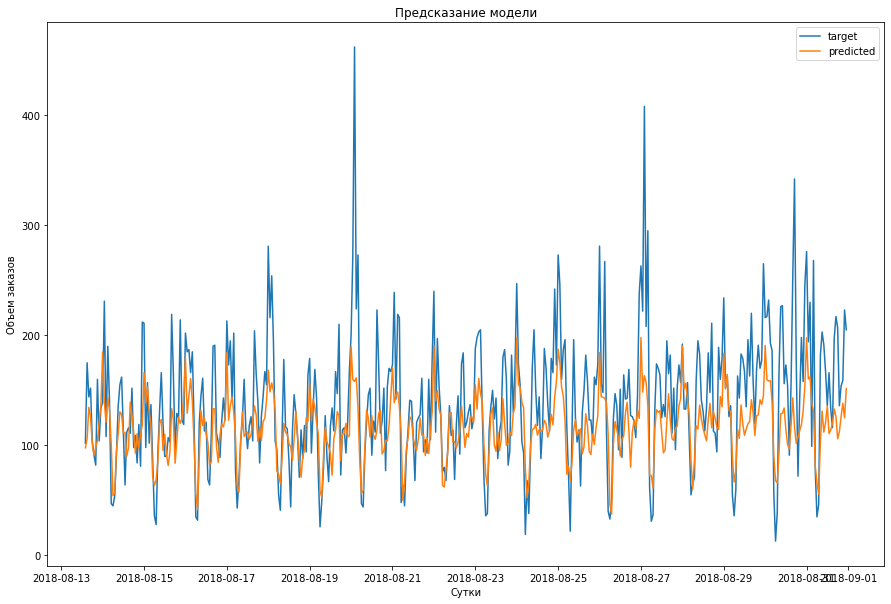

In [37]:
a = target_test.tolist()
b = predicted_test.tolist()
c = target_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.title('Предсказание модели')
plt.xlabel("Сутки")
plt.ylabel("Объем заказов")
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")

plt.legend()
plt.show()

Модель довольно хорошо предсказывает объем заказов в течение суток. Ошибается в пики 00:00 и 16:00, давая результат меньше реального.

In [38]:
dummy_regr = DummyRegressor(strategy="mean")

In [39]:
dummy_regr.fit(features_train, target_train)
predicted_test = dummy_regr.predict(features_test)

In [40]:
print("RMSE тестовой выборки:", mean_squared_error(target_test, predicted_test) ** 0.5)

RMSE тестовой выборки: 87.20279462388325


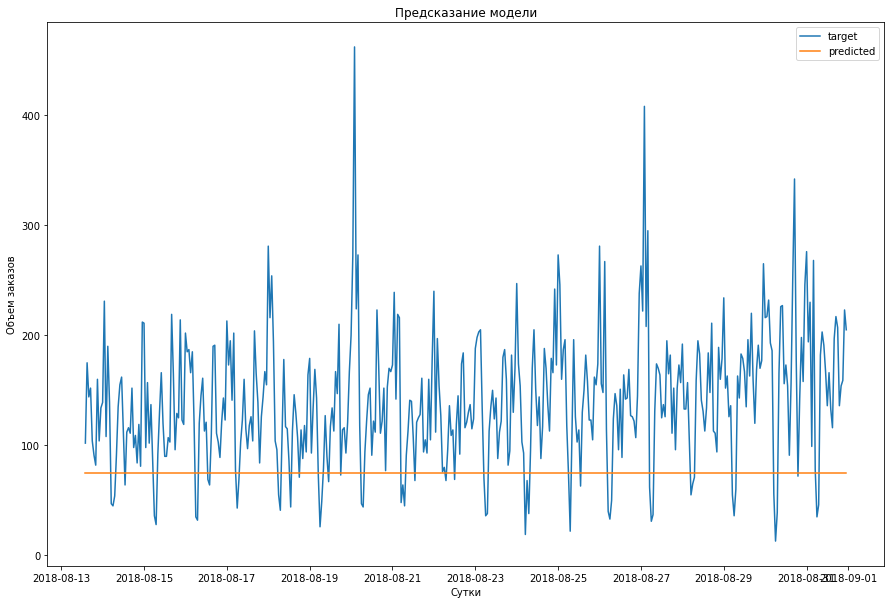

In [41]:
a = target_test.tolist()
b = predicted_test.tolist()
c = target_test.index.tolist()
plt.figure(figsize=(15, 10))
plt.title('Предсказание модели')
plt.xlabel("Сутки")
plt.ylabel("Объем заказов")
plt.plot(c, a, label = "target")
plt.plot(c, b, label = "predicted")

plt.legend()
plt.show()

Константная модель явно не подходит для решения задачи.

# Общий вывод

Была построена модель для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки. lgbm - модель с наилучшим RMSE, равным 47.06 на тестовой выборке. Время обучения в среднем равно 5 секундам.